# Vibration

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
import numpy as np
import pandas as pd
import h5py
import tensorflow as tf
import itertools
import seaborn as sns

from string import ascii_letters
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import RobustScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Flatten, Dense
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

%matplotlib inline

In [30]:
folder_path = "/content/drive/MyDrive/Paper/Dataset"

In [31]:
pd_tr = pd.read_csv(folder_path + '/vib_training_all.csv')
pd_v = pd.read_csv(folder_path + '/vib_validation_all.csv')

In [32]:
print(pd_tr.shape)
print(len(pd_tr))
print(len(pd_v))

(196032, 20)
196032
24522


In [33]:
np_tr = pd_tr.to_numpy()
np_v = pd_v.to_numpy()

# Extract Labels

In [34]:
x_labels = np_tr[:,-1] 
y_valid = np_v[:, -1] #일단 이건 맞는데

print(x_valid)
print(y_valid)

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


In [35]:
pd_tr = pd_tr.drop(columns = ['Date','WATT','LABEL'])
pd_v = pd_v.drop(columns = ['Date','WATT','LABEL'])

In [36]:
def draw_seaborn_corr(corr_data):
    sns.set_theme(style="white")

    # Generate a large random dataset
    rs = np.random.RandomState(33)
    mask = np.triu(np.ones_like(corr_data, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_data, mask=mask, cmap=cmap, vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})

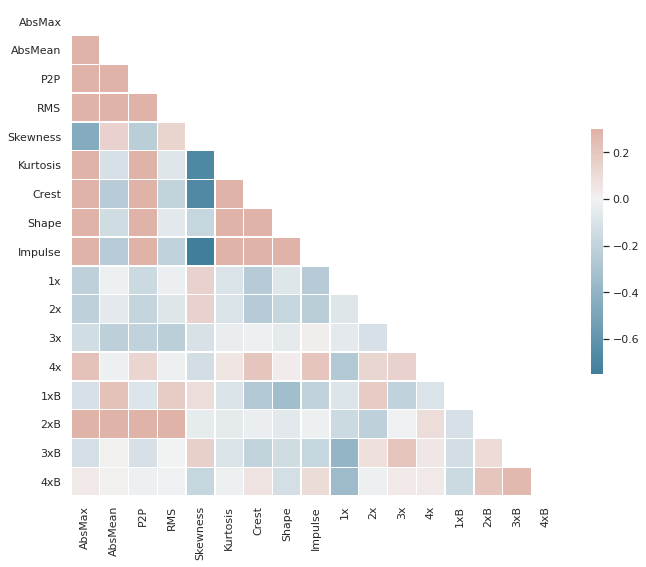

In [37]:
corr_pd_tr = pd_tr.corr()
draw_seaborn_corr(corr_pd_tr)

In [38]:
corr_pd_tr

,AbsMax,AbsMean,P2P,RMS,Skewness,Kurtosis,Crest,Shape,Impulse,1x,2x,3x,4x,1xB,2xB,3xB,4xB
AbsMax,1.000000,0.528098,0.946801,0.569757,-0.450931,0.466399,0.652750,0.362119,0.611035,-0.214545,-0.214541,-0.138042,0.230868,-0.117675,0.485529,-0.120817,0.037463
AbsMean,0.528098,1.000000,0.687341,0.995601,0.149286,-0.115853,-0.244340,-0.142729,-0.245273,-0.016804,-0.059769,-0.218253,-0.018527,0.224556,0.684238,0.007733,0.004736
P2P,0.946801,0.687341,1.000000,0.736576,-0.232354,0.357717,0.481191,0.403404,0.407343,-0.163508,-0.186635,-0.211808,0.139907,-0.089295,0.546248,-0.114555,-0.018126
RMS,0.569757,0.995601,0.736576,1.000000,0.143487,-0.080442,-0.192815,-0.062393,-0.207213,-0.021012,-0.073739,-0.225188,-0.015980,0.179567,0.685681,-0.005294,-0.009349
Skewness,-0.450931,0.149286,-0.232354,0.143487,1.000000,-0.677296,-0.672958,-0.178327,-0.750205,0.151842,0.148049,-0.107416,-0.125592,0.093996,-0.046541,0.158415,-0.178460
Kurtosis,0.466399,-0.115853,0.357717,-0.080442,-0.677296,1.000000,0.659086,0.521469,0.713869,-0.097327,-0.101915,-0.029508,0.051188,-0.095828,-0.052546,-0.099279,-0.012216
Crest,0.652750,-0.244340,0.481191,-0.192815,-0.672958,0.659086,1.000000,0.572274,0.948864,-0.252893,-0.252058,-0.017856,0.201888,-0.263300,-0.025602,-0.198329,0.068080
Shape,0.362119,-0.142729,0.403404,-0.062393,-0.178327,0.521469,0.572274,1.000000,0.572315,-0.072105,-0.178157,-0.052736,0.027181,-0.337590,-0.064607,-0.147123,-0.122358
Impulse,0.611035,-0.245273,0.407343,-0.207213,-0.750205,0.713869,0.948864,0.572315,1.000000,-0.250096,-0.237697,0.017320,0.210243,-0.207930,-0.017477,-0.178664,0.100132
1x,-0.214545,-0.016804,-0.163508,-0.021012,0.151842,-0.097327,-0.252893,-0.072105,-0.250096,1.000000,-0.075820,-0.058608,-0.266701,-0.086053,-0.162943,-0.390702,-0.354857


In [39]:
np_tr = pd_tr.to_numpy()
np_v = pd_v.to_numpy()

# 1. Current

In [40]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(pd_tr, x_labels, test_size=0.2, random_state=42)

In [41]:
print(x_train.shape)
print(y_train.shape)

print("="*50)

print(x_test.shape)
print(y_test.shape)

print("="*50)

x_valid = pd_v
# y_valid = vib_val_labels

print(x_valid.shape)
print(y_valid.shape)

(156825, 17)
(156825,)
(39207, 17)
(39207,)
(24522, 17)
(24522,)


# 1. 시각화

## 1.1 데이터 status 확인

In [42]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))  # classes = array([-1,  1])
classes

array([0, 1, 2, 3, 4], dtype=object)

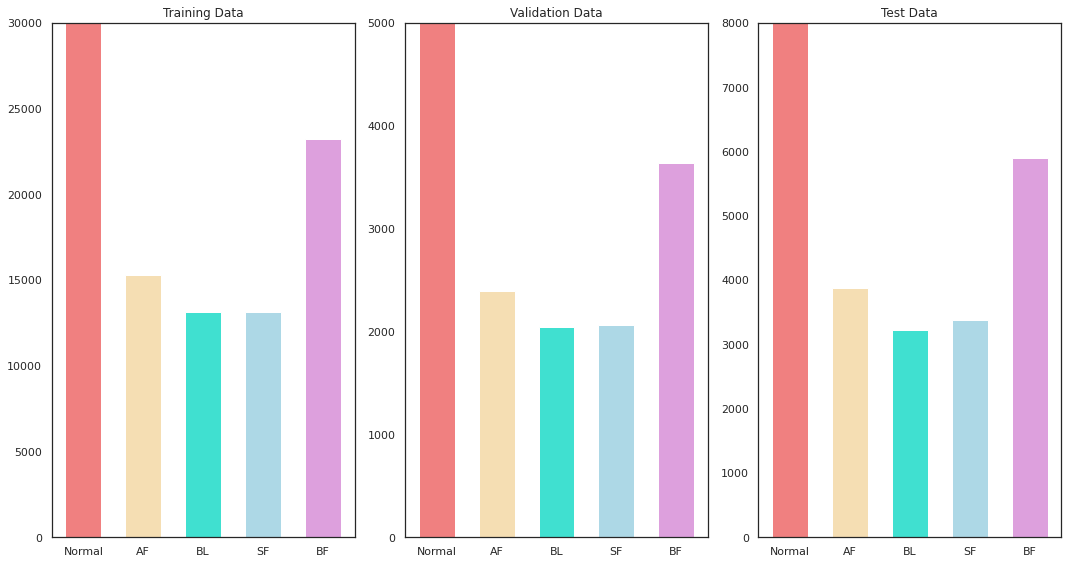

In [43]:
x = np.arange(len(classes))  # Plot의 X축의 개수 구하기

labels = ["Normal", "AF", "BL", "SF", "BF"]   # Plot의 X축의 이름 구하기

values_train = [(y_train == i).sum() for i in classes]  # Train 데이터의 정상/비정상 각 총 개수
values_valid = [(y_valid == i).sum() for i in classes]  # Test 데이터의 정상/비정상 각 총 개수
values_test = [(y_test == i).sum() for i in classes]  # Test 데이터의 정상/비정상 각 총 개수

plt.figure(figsize=(15,8))  # Plot 틀(Figure)의 Size 설정 (5X3)

plt.subplot(1,3,1)   # Plot 틀(Figure) 내 3개의 subplot 중 첫 번째(왼쪽) 지정
plt.title("Training Data")  # subplot 제목
plt.bar(x, values_train, width=0.6, color=["lightcoral", "wheat","turquoise","lightblue","plum"])  # Train 데이터의 정상/비정상 개수 BarPlot
plt.ylim([0, 30000])
plt.xticks(x, labels)  # X축에 변수 기입

plt.subplot(1,3,2)  # Plot 틀(Figure) 내 3개의 subplot 중 두 번째(가운데) 지정
plt.title("Validation Data")
plt.bar(x, values_valid, width=0.6,color=["lightcoral", "wheat","turquoise","lightblue","plum"])  # Test 데이터의 정상/비정상 개수 BarPlot
plt.ylim([0, 5000])
plt.xticks(x, labels)  

plt.subplot(1,3,3)  # Plot 틀(Figure) 내 3개의 subplot 중 세 번째(오른쪽) 지정
plt.title("Test Data")
plt.bar(x, values_test, width=0.6, color=["lightcoral", "wheat","turquoise","lightblue","plum"])  # Test 데이터의 정상/비정상 개수 BarPlot
plt.ylim([0, 8000])
plt.xticks(x, labels)

plt.tight_layout()  # 그림 저장
plt.savefig('100%_data_status.png', dpi=100, bbox_inches='tight')  # 그림 저장
plt.show()  # 그림 출력

# Normalize

In [44]:
# CNN, RNN 모델의 입력 변수는 채널 축 1개 차원을 확장시킨 3D Tensor이다.
# 즉 아래 CNN, RNN 모델은 x_train, x_valid, x_test를 입력 변수로 넣지 않고, 
# x_train_exp, x_valid_exp, x_test_exp을 넣는다. 
x_train_exp = np.expand_dims(x_train, -1)  # 채널 축 1개 차원을 확장 시킨(Expand) X_train
x_valid_exp = np.expand_dims(x_valid, -1)  # 채널 축 1개 차원을 확장 시킨(Expand) X_vaild 
x_test_exp = np.expand_dims(x_test, -1)  # 채널 축 1개 차원을 확장 시킨(Expand) X_test

# 위와 동일한 코드
# x_train_exp = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
# x_valid_exp = x_train.reshape((x_valid.shape[0], x_valid.shape[1], 1))
# x_test_exp = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

print("x_train_exp의 형태:", x_train_exp.shape)
print("y_train_exp의 형태:", y_train.shape)

print("=" * 50)

print("x_valid_exp의 형태:", x_valid_exp.shape)
print("y_valid_exp의 형태:", y_valid.shape)

print("=" * 50)

print("x_test_exp의 형태:", x_test_exp.shape)
print("y_test_exp의 형태:", y_test.shape)

x_train_exp의 형태: (156825, 17, 1)
y_train_exp의 형태: (156825,)
x_valid_exp의 형태: (24522, 17, 1)
y_valid_exp의 형태: (24522,)
x_test_exp의 형태: (39207, 17, 1)
y_test_exp의 형태: (39207,)


In [45]:
x_train_exp = np.asarray(x_train_exp).astype('float32')
x_test_exp = np.asarray(x_test_exp).astype('float32')
x_valid_exp = np.asarray(x_valid_exp).astype('float32')

y_train = np.asarray(y_train).astype('float32')
y_valid = np.asarray(y_valid).astype('float32')
y_test = np.asarray(y_test).astype('float32')

# LSTM

In [46]:
def make_lstm_model():
    model=Sequential()
    model.add(LSTM(units=256, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model. add(Dense(5, activation='softmax'))
    return model

In [47]:
lstm = make_lstm_model()

In [48]:
EPOCHS = 300
BATCH_SIZE = 64

In [49]:
lstm.compile(loss="sparse_categorical_crossentropy", 
                  optimizer='adam', 
                  metrics=["accuracy"]
                 )

In [50]:
callbacks = [ModelCheckpoint(folder_path + '/best_model.h5',
                             monitor='val_loss',
                             save_best_only=True),
             ReduceLROnPlateau(
                 monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
                 ),
             EarlyStopping(monitor="val_loss", patience=10, verbose=1)
             ]

In [51]:
history = lstm.fit(
    x_train_exp,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=(x_valid_exp, y_valid),
    verbose=1
)

Epoch 1/300
2451/2451 [==============================] - 13s 5ms/step - loss: 0.7189 - accuracy: 0.6974 - val_loss: 0.2345 - val_accuracy: 0.9071
Epoch 2/300
2451/2451 [==============================] - 11s 4ms/step - loss: 0.3153 - accuracy: 0.8672 - val_loss: 0.1186 - val_accuracy: 0.9578
Epoch 3/300
2451/2451 [==============================] - 11s 4ms/step - loss: 0.1663 - accuracy: 0.9350 - val_loss: 0.1150 - val_accuracy: 0.9590
Epoch 4/300
2451/2451 [==============================] - 11s 4ms/step - loss: 0.1389 - accuracy: 0.9457 - val_loss: 0.2115 - val_accuracy: 0.9076
Epoch 5/300
2451/2451 [==============================] - 11s 4ms/step - loss: 0.1307 - accuracy: 0.9498 - val_loss: 0.2152 - val_accuracy: 0.9248
Epoch 6/300
2451/2451 [==============================] - 11s 4ms/step - loss: 0.1191 - accuracy: 0.9532 - val_loss: 0.1455 - val_accuracy: 0.9496
Epoch 7/300
2451/2451 [==============================] - 11s 4ms/step - loss: 0.1106 - accuracy: 0.9573 - val_loss: 0.1161 -

In [52]:
scores = lstm.evaluate(x_test_exp, y_test)

print("\n""Test accuracy", scores[1])
print("\n""Test loss", scores[0])
print("%s: %.2f%%" % (lstm.metrics_names[1], scores[1]*100))

1226/1226 [==============================] - 3s 3ms/step - loss: 0.0485 - accuracy: 0.9806

Test accuracy 0.9805902242660522

Test loss 0.04849676787853241
accuracy: 98.06%


In [81]:
from sklearn.metrics import roc_curve, auc

y_pred = lstm.predict(x_test_exp).ravel()

In [91]:
y_pred2 = lstm.predict(x_test_exp)

In [89]:
y_true = [0,1,2,3,4]

In [84]:
len(y_pred)

196035

In [87]:
len(y_test) + len(y_train)

196032

In [92]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true, y_pred2)

ValueError: ignored

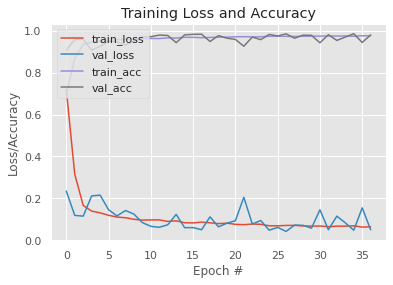

In [96]:
plt.style.use("ggplot")
plt.figure()
N = 37
H = history
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

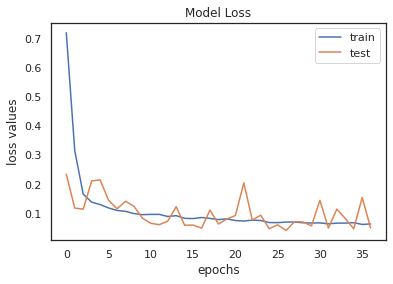

In [66]:
# plot loss during training

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Model Loss')
plt.xlabel('epochs')
plt.ylabel('loss values')
plt.legend(loc='upper right')
plt.show()

In [80]:
# %%Accuracy

print("Accuracy:",metrics.accuracy_score(np.argmax(y_test, axis=1),y_pred))

# %%f1 score

print("f1_weighted:",metrics.f1_score(np.argmax(y_test, axis=1), y_pred, average='weighted'))

AxisError: ignored